# DeepDreaming with TensorFlow

Based on https://www.tensorflow.org/tutorials/generative/deepdream

In [ ]:
!nvidia-smi

Sat Oct 29 04:52:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    45W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
import matplotlib as mpl

import IPython.display as display
import PIL.Image

import time


2.9.2


### Load and display image

In [ ]:
# url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/6/67/Blick_aus_der_Mount_Pilatus.jpg/1200px-Blick_aus_der_Mount_Pilatus.jpg?20201114093820'

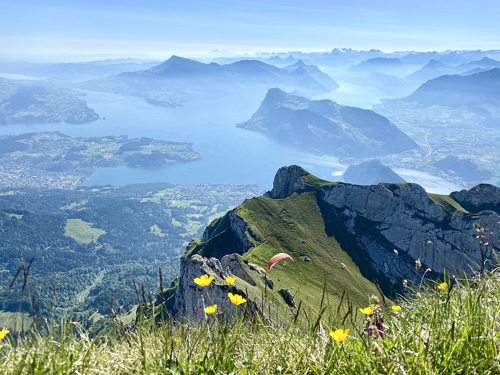

In [ ]:
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image (from [-1,1] to [0,255])
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)
# display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)


In [ ]:
[it.name for it in base_model.layers]

['input_1',
 'conv2d',
 'batch_normalization',
 'activation',
 'conv2d_1',
 'batch_normalization_1',
 'activation_1',
 'conv2d_2',
 'batch_normalization_2',
 'activation_2',
 'max_pooling2d',
 'conv2d_3',
 'batch_normalization_3',
 'activation_3',
 'conv2d_4',
 'batch_normalization_4',
 'activation_4',
 'max_pooling2d_1',
 'conv2d_8',
 'batch_normalization_8',
 'activation_8',
 'conv2d_6',
 'conv2d_9',
 'batch_normalization_6',
 'batch_normalization_9',
 'activation_6',
 'activation_9',
 'average_pooling2d',
 'conv2d_5',
 'conv2d_7',
 'conv2d_10',
 'conv2d_11',
 'batch_normalization_5',
 'batch_normalization_7',
 'batch_normalization_10',
 'batch_normalization_11',
 'activation_5',
 'activation_7',
 'activation_10',
 'activation_11',
 'mixed0',
 'conv2d_15',
 'batch_normalization_15',
 'activation_15',
 'conv2d_13',
 'conv2d_16',
 'batch_normalization_13',
 'batch_normalization_16',
 'activation_13',
 'activation_16',
 'average_pooling2d_1',
 'conv2d_12',
 'conv2d_14',
 'conv2d_17',
 '

In [ ]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(tf.square(act))
    #print(loss)
    losses.append(loss)

  return  tf.reduce_sum(losses)

### Laplace Smoothing

In [ ]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  #maxroll=1
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[0,1])
  return shift, img_rolled

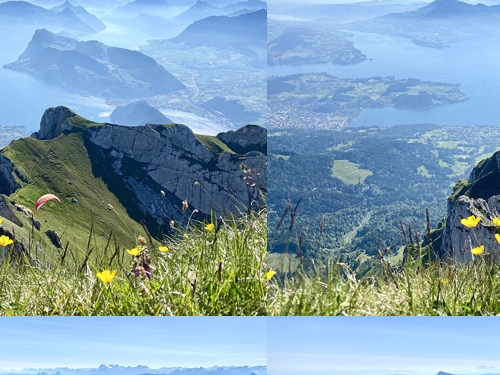

In [ ]:
shift, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)

In [ ]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[2], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, img_size, tile_size=256):
    shift, img_rolled = random_roll(img, tile_size)

    #show(img_rolled)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)

    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_size[1], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_size[0], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    print('***', len(xs), len(ys))
    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[y:y+tile_size, x:x+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients

In [ ]:
get_tiled_gradients = TiledGradients(dream_model)

In [ ]:
k = np.float32([1,4,6,4,1])
k = np.outer(k, k)
k5x5 = k[:,:,None,None]/k.sum()*np.eye(3, dtype=np.float32)

def lap_split(img):
    '''Split the image into lo and hi frequency components'''
    with tf.name_scope('split'):
        lo = tf.nn.conv2d(img, k5x5, [1,2,2,1], 'SAME')
        lo2 = tf.nn.conv2d_transpose(lo, k5x5*4, tf.shape(img), [1,2,2,1])
        hi = img-lo2
    return lo, hi

def lap_split_n(img, n):
    '''Build Laplacian pyramid with n splits'''
    levels = []
    for i in range(n):
        img, hi = lap_split(img)
        levels.append(hi)
    levels.append(img)
    return levels[::-1]

def lap_merge(levels):
    '''Merge Laplacian pyramid'''
    img = levels[0]
    for hi in levels[1:]:
        with tf.name_scope('merge'):
            img = tf.nn.conv2d_transpose(img, k5x5*4, tf.shape(hi), [1,2,2,1]) + hi
    return img

def normalize_std(img, eps=1e-10):
    '''Normalize image by making its standard deviation = 1.0'''
    with tf.name_scope('normalize'):
        std = tf.sqrt(tf.reduce_mean(tf.square(img)))
        return img/tf.maximum(std, eps)

def lap_normalize(img, scale_n=4):
    '''Perform the Laplacian pyramid normalization.'''
    img = tf.expand_dims(img,0)
    tlevels = lap_split_n(img, scale_n)
    tlevels = list(map(normalize_std, tlevels))
    out = lap_merge(tlevels)
    return out[0,:,:,:]



In [33]:
def run_deep_dream_laplace(img, steps_per_octave=20, step_size=0.001, 
                                octaves=range(-2,3), octave_scale=1.3, lap_scale_n=2):
  base_shape = tf.shape(img)
  img = tf.keras.utils.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    new_size = tf.cast(new_size, tf.int32)
    img = tf.image.resize(img, new_size)

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img, new_size)
      gradients = lap_normalize(gradients,scale_n=lap_scale_n)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        #display.clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))

  result = deprocess(img)
  return result

In [34]:
img = run_deep_dream_laplace(img=original_img, octaves=range(-3,3), steps_per_octave=30, step_size=0.001, lap_scale_n=4)


Output hidden; open in https://colab.research.google.com to view.

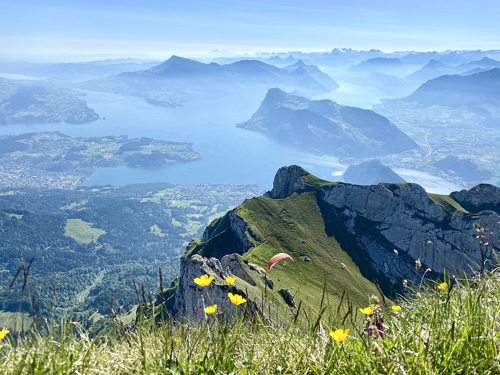

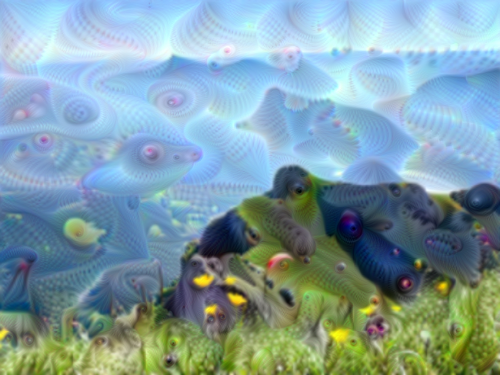

In [35]:
base_shape = tf.shape(original_img)[:-1]
display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(original_img)
show(img)